In [2]:
import numpy as np
import cirq
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
from openparticle import ParticleOperator, Fock
from openparticle.utils import generate_matrix, get_fock_basis
import math
from functools import reduce, partial
from symmer import QuantumState

import sys, os
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '../'))

from src.lobe.fermionic import fermionic_product_block_encoding, fermionic_plus_hc_block_encoding
from src.lobe.system import System
from src.lobe.metrics import CircuitMetrics
from src.lobe.multiplexed_rotations import get_decomposed_multiplexed_rotation_circuit
from src.lobe._utils import _apply_negative_identity, get_basis_of_full_system, get_fermionic_operator_types, pretty_print, get_bosonic_exponents
from src.lobe.bosonic import _get_bosonic_rotation_angles, _add_multi_bosonic_rotations, bosonic_product_block_encoding
from src.lobe.addition import add_classical_value
from src.lobe.decompose import decompose_controls_left, decompose_controls_right
from src.lobe.index import index_over_terms
from src.lobe.asp import add_prepare_circuit, get_target_state
from src.lobe.reflection import add_ancilla_reflection
from src.lobe.qpe_utils import *

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
plt.rc('text', usetex=True)
import warnings
warnings.filterwarnings('ignore')

In [286]:
Omega = 3

hamiltonian_operator = (
    ParticleOperator('a0^ a0') +  ParticleOperator('a1^ a1')
)

rescaling_factor = 2 * Omega
basis = get_basis_of_full_system(Omega + 1, 0, 2)
H_matrix = generate_matrix(hamiltonian_operator, basis)
vals, vecs = np.linalg.eigh(H_matrix)

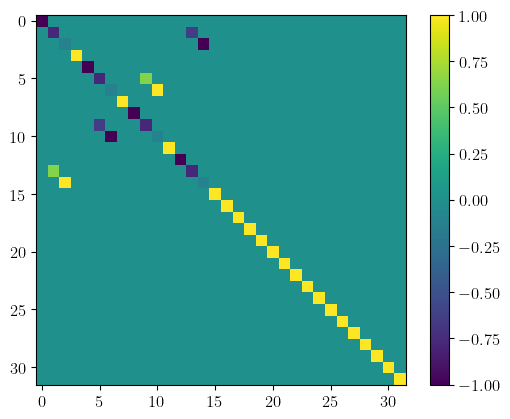

In [272]:
plt.imshow((cirq.Circuit(test_gates).unitary()).real)
plt.colorbar()

In [234]:
U = [
    cirq.ry(np.pi).on(cirq.LineQubit(0)).controlled_by(*[cirq.LineQubit(1), cirq.LineQubit(2)], control_values = [0, 0]),
    cirq.ry(np.pi/2).on(cirq.LineQubit(0)).controlled_by(*[cirq.LineQubit(1), cirq.LineQubit(2)], control_values = [0, 1]),
    cirq.ry(np.pi/3).on(cirq.LineQubit(0)).controlled_by(*[cirq.LineQubit(1), cirq.LineQubit(2)], control_values = [1, 0]),
    cirq.ry(np.pi/4).on(cirq.LineQubit(0)).controlled_by(*[cirq.LineQubit(1), cirq.LineQubit(2)], control_values = [1, 1])
]

U_test = [
    cirq.ry(-np.pi/4).on(cirq.LineQubit(0)).controlled_by(*[cirq.LineQubit(1), cirq.LineQubit(2)], control_values = [1, 1]),
    cirq.ry(-np.pi/3).on(cirq.LineQubit(0)).controlled_by(*[cirq.LineQubit(1), cirq.LineQubit(2)], control_values = [1, 0]),
    cirq.ry(-np.pi/2).on(cirq.LineQubit(0)).controlled_by(*[cirq.LineQubit(1), cirq.LineQubit(2)], control_values = [0, 1]),
    cirq.ry(-np.pi).on(cirq.LineQubit(0)).controlled_by(*[cirq.LineQubit(1), cirq.LineQubit(2)], control_values = [0, 0]),
]
U_test_2 = [
    cirq.ry(-np.pi).on(cirq.LineQubit(0)).controlled_by(*[cirq.LineQubit(1), cirq.LineQubit(2)], control_values = [0, 0]),
    cirq.ry(-np.pi/2).on(cirq.LineQubit(0)).controlled_by(*[cirq.LineQubit(1), cirq.LineQubit(2)], control_values = [0, 1]),
    cirq.ry(-np.pi/3).on(cirq.LineQubit(0)).controlled_by(*[cirq.LineQubit(1), cirq.LineQubit(2)], control_values = [1, 0]),
    cirq.ry(-np.pi/4).on(cirq.LineQubit(0)).controlled_by(*[cirq.LineQubit(1), cirq.LineQubit(2)], control_values = [1, 1])
]

np.allclose(cirq.Circuit(U).unitary().conj().T, cirq.Circuit(U_test_2).unitary())


True

In [218]:
for index, gate in enumerate(U):
    print(index, gate._sub_operation._gate._rads)

0 3.141592653589793
1 1.5707963267948966
2 1.0471975511965976
3 0.7853981633974483


In [294]:
def self_inverse_bosonic_number_operator_block_encoding(
        system,
        block_encoding_ancillae,
        active_mode,
        sign=1,
        clean_ancillae=[],
        ctrls=([], []),
):
    """
    A self inverse block-encoding of the operator a_i^\dagger a_i
    Args:
        - system (lobe.system.System): The system object holding the system registers
        - block_encoding_ancillae (List[cirq.LineQubit]): The block-encoding ancillae qubits
        - active_mode (int): The mode upon which the ladder operator acts.
        - sign (int): Either 1 or -1 to indicate the sign of the term
        - clean_ancillae (List[cirq.LineQubit]): A list of qubits that are promised to start and end in the 0-state.
        - ctrls (Tuple(List[cirq.LineQubit], List[int])): A set of qubits and integers that correspond to
            the control qubits and values.

     Returns:
        - List of cirq operations representing the gates to be applied in the circuit
        - CircuitMetrics object representing cost of block-encoding circuit
    """
    gates = []
    

    hermiticity_index_qubit = block_encoding_ancillae[0]
    rotation_qubit = block_encoding_ancillae[1]
    if sign == -1:
        gates += _apply_negative_identity(hermiticity_index_qubit, ctrls=ctrls)

    gates.append(cirq.H.on(hermiticity_index_qubit))


    left_elbow, _ = decompose_controls_left(
        (ctrls[0] + [hermiticity_index_qubit], ctrls[1] + [1]), clean_ancillae[0]
    )
    gates.append(left_elbow)
    gates.append(
        cirq.X.on(rotation_qubit).controlled_by(clean_ancillae[0])
    )



    rotation_gates, _ = _add_multi_bosonic_rotations(
        rotation_qubit,
        system.bosonic_modes[active_mode],
        creation_exponent=1,
        annihilation_exponent=1,
        clean_ancillae=clean_ancillae,
        ctrls=([], []),
    )
    gates.append(rotation_gates)
    gates.append(
        cirq.X.on(rotation_qubit).controlled_by(clean_ancillae[0])
    )
    right_elbow, _ = decompose_controls_right(
            (ctrls[0] + [hermiticity_index_qubit], ctrls[1] + [1]), clean_ancillae[0]
    )
    gates.append(right_elbow)
  
    gates.append(cirq.X.on(hermiticity_index_qubit))
    gates.append(cirq.H.on(hermiticity_index_qubit))


    return gates

In [295]:
index_register = [cirq.LineQubit(0)]
clean_ancilla_register = [cirq.LineQubit(i) for i in range(1, 5 + 1)]
be_anc_register = [cirq.LineQubit(6), cirq.LineQubit(7)]
system_register = System(Omega, 
                    len(index_register) + len(clean_ancilla_register) + len(be_anc_register),
                    0, 
                    1)

SELECT = self_inverse_bosonic_number_operator_block_encoding(
    system = system_register,
    block_encoding_ancillae=be_anc_register,
    active_mode = 0,
    sign = 1,
    clean_ancillae=clean_ancilla_register,
    ctrls = ([index_register[0]], [1])
)


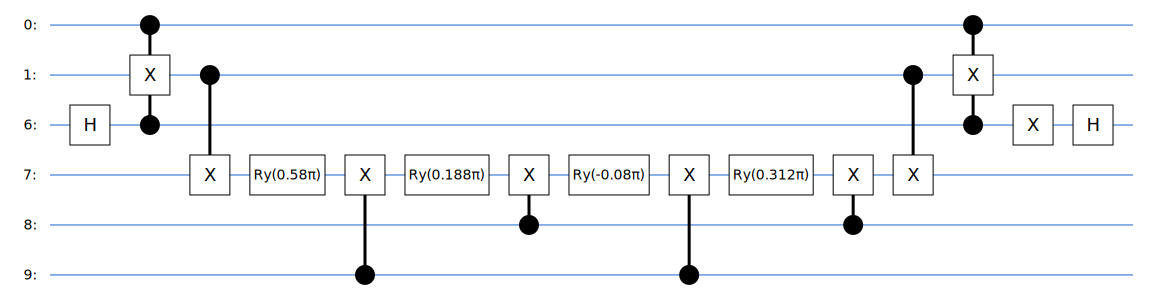

In [281]:
SVGCircuit(cirq.Circuit(SELECT))

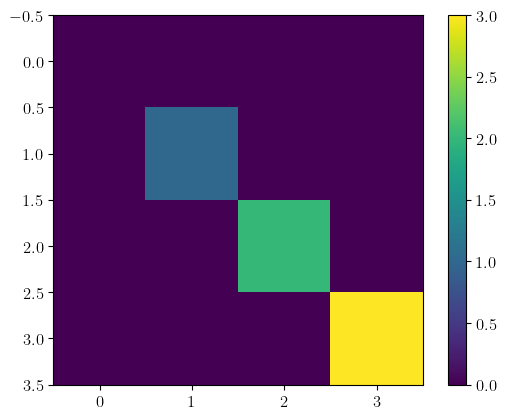

In [289]:
plt.imshow((cirq.Circuit(
    cirq.X.on(index_register[0]),
    SELECT ,
    cirq.X.on(index_register[0])
).unitary()*Omega)[:4, :4].real)
plt.colorbar()


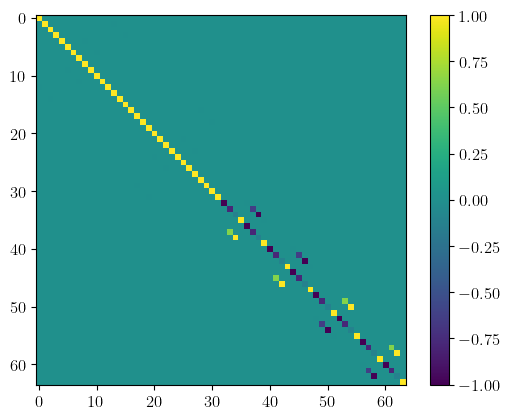

In [293]:
plt.imshow(cirq.Circuit(
    cirq.X.on(index_register[0]),
    SELECT,
    SELECT,
    cirq.X.on(index_register[0])
).unitary().real)
plt.colorbar()

In [66]:
coefficient_vector = [term.coeff if len(term) == 1 else term.coeffs[0] for term in hamiltonian_operator.group()]
target_state = get_target_state(coefficients=coefficient_vector)



system = System(Omega, 
                len(phase_register) + len(index_register) + len(clean_ancilla_register) + len(block_encoding_ancilla_register),
                0, 
                hamiltonian_operator.max_mode + 1)

In [12]:
def adapted_bosonic_product_plus_hc_block_encoding(
    system,
    block_encoding_ancillae,
    sign=1,
    clean_ancillae=[],
    ctrls=([], []),
):

    assert len(ctrls[0]) <= 1
    if len(ctrls[0]) == 1:
        assert ctrls[1] == [1]

    gates = []
    block_encoding_metrics = CircuitMetrics()
    rotation_qubit = block_encoding_ancillae[0]
    select_index = block_encoding_ancillae[1]
    operator_index = block_encoding_ancillae[2]
    if sign == -1:
        gates += _apply_negative_identity(rotation_qubit, ctrls=ctrls)

    gates.append(cirq.H.on(select_index))
    gates.append(cirq.H.on(operator_index))

    gates.append(cirq.X.on(operator_index).controlled_by(select_index))

    adder_gates, adder_metrics = add_classical_value(
        list(system.bosonic_modes[0]),
        1,
        clean_ancillae=clean_ancillae,
        ctrls=([operator_index], [0]),
    )
    gates += adder_gates
    block_encoding_metrics += adder_metrics

    gates.append(cirq.X.on(rotation_qubit).controlled_by(select_index))
    rotation_gates, rotation_metrics = _add_multi_bosonic_rotations(
        rotation_qubit,
        list(system.bosonic_modes[0]),
        1,
        0,
        clean_ancillae=clean_ancillae,
        ctrls=ctrls,
    )
    gates += rotation_gates
    block_encoding_metrics += rotation_metrics
    gates.append(cirq.X.on(rotation_qubit).controlled_by(select_index))

    adder_gates, adder_metrics = add_classical_value(
        list(system.bosonic_modes[0]),
        -1,
        clean_ancillae=clean_ancillae,
        ctrls=([operator_index], [1]),
    )
    gates += adder_gates
    block_encoding_metrics += adder_metrics
    
    gates.append(cirq.X.on(operator_index).controlled_by(select_index))

    # reflection_gates = add_ancilla_reflection([operator_index])
    # gates += reflection_gates
        
    gates.append(cirq.X.on(select_index))
    gates.append(cirq.H.on(select_index))
    gates.append(cirq.H.on(operator_index))

    return gates, block_encoding_metrics

In [4]:
Omega = 3

hamiltonian_operator = (
    ParticleOperator('a0^ a0') +  ParticleOperator('a1^ a1')
)

rescaling_factor = 2 * Omega
basis = get_basis_of_full_system(Omega + 1, 0, 2)
H_matrix = generate_matrix(hamiltonian_operator, basis)
vals, vecs = np.linalg.eigh(H_matrix)

In [5]:
n_phase_bits = 4

n_index_qubits = 1
n_clean_ancilla = 3
n_be_ancilla = 2
n_system_qubits = (hamiltonian_operator.max_bosonic_mode + 1) * int(np.ceil(np.log2(Omega + 1)))

n_qubits = n_phase_bits + n_index_qubits + n_clean_ancilla + n_be_ancilla + n_system_qubits

qubits = [cirq.LineQubit(i) for i in range(n_qubits)]
phase_register = qubits[:n_phase_bits]
index_register = qubits[n_phase_bits: n_phase_bits + n_index_qubits]
clean_ancilla_register = qubits[n_phase_bits + n_index_qubits: n_phase_bits + n_index_qubits + n_clean_ancilla]
block_encoding_ancilla_register = qubits[n_phase_bits + n_index_qubits + n_clean_ancilla:n_phase_bits + n_index_qubits + n_clean_ancilla + n_be_ancilla]
system_register = qubits[n_phase_bits + n_index_qubits + n_clean_ancilla + n_be_ancilla:]


In [11]:
coefficient_vector = [term.coeff if len(term) == 1 else term.coeffs[0] for term in hamiltonian_operator.group()]
target_state = get_target_state(coefficients=coefficient_vector)



system = System(Omega, 
                len(phase_register) + len(index_register) + len(clean_ancilla_register) + len(block_encoding_ancilla_register),
                0, 
                hamiltonian_operator.max_mode + 1)

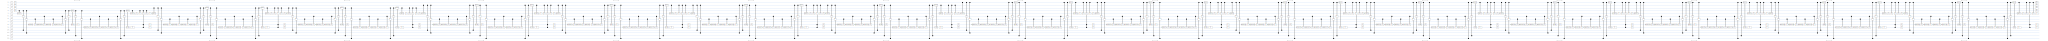

In [93]:
circuit = cirq.Circuit()
circuit.append(cirq.I.on_each(*qubits))

for qubit in phase_register:
    circuit.append(cirq.H.on(qubit))



for i, qubit in enumerate(phase_register[::-1]):
    for _ in range(1<<i):
        prepare_gates, _ = add_prepare_circuit(index_register, target_state, dagger=False, clean_ancillae=clean_ancilla_register, ctrls=([qubit], [1]))
        circuit += prepare_gates
        
        select_gates, _ = _add_multi_bosonic_rotations(
            block_encoding_ancilla_register[0],
            system.bosonic_modes[0],
            creation_exponent=1,
            annihilation_exponent=1,
            clean_ancillae=clean_ancilla_register,
            ctrls=([qubit], [1]),
        )
        circuit += select_gates

        select_gates, _ = _add_multi_bosonic_rotations(
            block_encoding_ancilla_register[1],
            system.bosonic_modes[1],
            creation_exponent=1,
            annihilation_exponent=1,
            clean_ancillae=clean_ancilla_register,
            ctrls=([qubit], [1]),
        )
        circuit += select_gates

        prepare_dagger_gates, _ = add_prepare_circuit(index_register, target_state, dagger=True, clean_ancillae=clean_ancilla_register, ctrls=([qubit], [1]))
        circuit += prepare_dagger_gates
        
        refl_gates = add_ancilla_reflection(index_register+block_encoding_ancilla_register, ctrls=([qubit], [1]))
        circuit += refl_gates

circuit.append(cirq.qft(*phase_register, inverse=True))
SVGCircuit(circuit)

In [89]:
excitation_level = 2

#Initial state 
phase_state = np.zeros(1<<n_phase_bits) 
phase_state[0] = 1 #|0>^o\times n_phase_bits

index_clean_be_anc = np.zeros(1 << (n_index_qubits + n_clean_ancilla + n_be_ancilla))
index_clean_be_anc[0] = 1
system_state = vecs[:, excitation_level]

full_initial_state = np.kron(
    phase_state.flatten(),
    np.kron(
        index_clean_be_anc.flatten(), system_state.flatten()
    )
)

print("---Initial---")
print(pretty_print(full_initial_state.flatten(), [n_phase_bits, n_index_qubits, n_clean_ancilla, n_be_ancilla, n_system_qubits], 1e-4))

state = cirq.Simulator().simulate(circuit, initial_state=full_initial_state.flatten()).final_state_vector
print("---Final---")
print(pretty_print(state, [n_phase_bits, n_index_qubits, n_clean_ancilla, n_be_ancilla, n_system_qubits], 1e-4))

---Initial---
(1+0j)           |000000|0|000|00|0100>

---Final---
(0.056+0j)       |000000|0|000|00|0100>
(0.167+0j)       |000000|0|000|01|0100>
(-0.157+0j)      |000000|0|000|10|0100>
(0.444+0j)       |010000|0|000|00|0100>
(0.157+0j)       |010000|0|000|10|0100>
-0.471j          |010000|0|000|11|0100>
(0.056+0j)       |100000|0|000|00|0100>
(-0.167+0j)      |100000|0|000|01|0100>
(-0.157+0j)      |100000|0|000|10|0100>
(0.444-0j)       |110000|0|000|00|0100>
(0.157-0j)       |110000|0|000|10|0100>
0.471j           |110000|0|000|11|0100>



In [90]:
probabilities = simulate_circuit_and_compute_probabilities(circuit, full_initial_state, n_phase_bits)
eigenphases = list_possible_eigenphases(n_phase_bits)

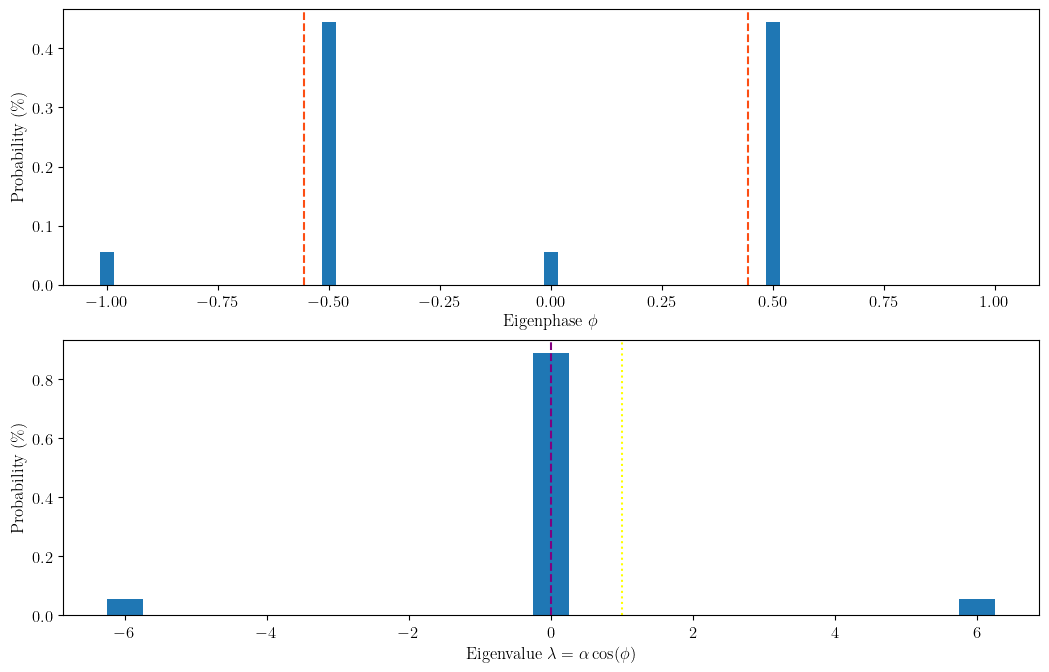

In [91]:
fig, axes = plt.subplots(2, 1, figsize=(32 / 2.54, 20 / 2.54))

# axes[0].bar(names, counts, width = 0.02)
axes[0].bar(eigenphases, probabilities, width=2/(1<<n_phase_bits))

alpha_plot_scale = 0
if n_phase_bits < 5:
    alpha_plot_scale = 0.75

for possible_eigenphase in eigenphases:
    axes[0].axvline(x = possible_eigenphase, color = 'k', linestyle = ':', alpha = alpha_plot_scale, zorder = -1)
axes[0].set_ylabel(r'Probability ($\%$)')
axes[0].set_xlabel(f"Eigenphase $\phi$")
axes[0].set_xlim(-1.1, 1.1)
# axes[0].set_ylim(0, 100)
negative_numerical_value = expected_value_of_eigenphase(eigenphases[:int(len(eigenphases)/2)], 2*probabilities[:int(len(eigenphases)/2)])
positive_numerical_value = expected_value_of_eigenphase(eigenphases[int(len(eigenphases)/2):], 2*probabilities[int(len(eigenphases)/2):])
axes[0].axvline(x=positive_numerical_value, color="#FC4E14", ls="--", label="Numerical")
axes[0].axvline(x=negative_numerical_value, color="#FC4E14", ls="--", label="Numerical")


energies = np.array([decode_eigenphase(eigenphase, rescaling_factor) for eigenphase in eigenphases]) #-1*np.cos(np.array(eigenphases)*np.pi)
parsed_energies = energies[:int(len(energies)/2) + 1]
parsed_probabilities = np.array(probabilities[:int(len(energies)/2) + 1])
for i, prob in enumerate(probabilities[int(len(energies)/2) + 1:]):
    parsed_probabilities[-2 - i] += prob
bar_plot = axes[1].bar(parsed_energies, parsed_probabilities, width=32/(1<<n_phase_bits))

axes[1].set_ylabel(r'Probability ($\%$)')
axes[1].set_xlabel(r"Eigenvalue $\lambda = \alpha \cos(\phi)$")

estimated_energy = np.average(
    [decode_eigenphase(positive_numerical_value, rescaling_factor),
    decode_eigenphase(negative_numerical_value, rescaling_factor)]
)
axes[1].axvline(x=estimated_energy, color="purple", ls="--", label="Numerical Average")
axes[1].axvline(x=vals[excitation_level], color="yellow", ls=":", label="Analytical Expectation")

# axes[0].set_title(f"$|E> = {QuantumState.from_array(vecs[:, excitation_level].reshape(-1, 1))}, E = {vals[excitation_level].round(3)}, \\arccos (-E/\\alpha) = {(np.arccos(-rescaled_vals[excitation_level])/np.pi).round(3)} \\pi$")
